In [1]:
import time
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import healpy as hp
from scipy import interpolate
import os

from combined_fit import spectrum as sp
from combined_fit import tensor as ts
from combined_fit import constant, map, draw, utilities

In [2]:
# Threshold energy above which the map is computed and tensor
Dmin, Dcut = 0.01, 350#Mpc, minimum and maximum distance of the catalog
galCoord = True # galactic coordinates if True, equatorial otherwise
logEth_map = 19.6#Threshold energy for computation
SavePlot = False#True to save the map
isSFR = True# True for SFRD, False for SMD

#Best-fit parameters, inferred with Examples/Fit.py
logRmin = 17.8 #Integrate the injected spectrum from logR_min to get total energy x k	
Tensor = ts.upload_Tensor(logRmin = logRmin, logEmin = logEth_map)

A= [1,4,14,28,56]
Z= [1, 2,  7,14, 26]

In [3]:
hadr_model = "Sibyll" #for the record
if isSFR:
    key, trac = "sfrd", "logSFR"#solar mass / (yr.Mpc3), mass/yr
    k_transient = 1E-4# best-case for B_LS = 10 nG
    text_k = r"$k = "+ draw.latex_float(k_transient) + r"\, M_\odot^{-1}$"
    logRcut, gamma_nucl, gamma_p =  18.24, -0.46, 3.54
    E_times_k = [1.79E+46, 8.18E+45, 1.96E+46, 8.55E+45, 1.52E45]
    unit_E_times_k = "erg per solar mass"
    sigma_shift_sys = 0.87
else:
    key, trac = "smd", "logM*"#solar mass / Mpc3, mass
    k_transient = 1E-15# best-case for B_LS = 10 nG
    text_k = r"$\dot{k} = "+ draw.latex_float(k_transient) + r"\, M_\odot^{-1}\, {yr}^{-1}$"
    logRcut, gamma_nucl, gamma_p =  18.33, 0.30, 3.44
    E_times_k = [2.63E+36, 6.20E+35, 9.23E+35, 3.73E+35, 1.36E35]
    unit_E_times_k = "erg per solar mass per year"
    sigma_shift_sys = 1.00

In [4]:
################# Compute the flux map ####################################
###########################################################################

####################### Background ########################################
#Weights for total and background-only evolution
S_z = ts.Load_evol(file = key+"_local.dat", key=key)
w_zR_nucl = sp.weight_tensor(S_z, gamma_nucl, logRcut)
w_zR_p = sp.weight_tensor(S_z, gamma_p, logRcut)

S_z_bckgnd_only = lambda z: S_z(z)*(constant._fz_DL(z)>Dcut)	
w_zR_bckgnd_nucl = sp.weight_tensor(S_z_bckgnd_only, gamma_nucl, logRcut)
w_zR_bckgnd_p = sp.weight_tensor(S_z_bckgnd_only, gamma_p, logRcut)

# Background and foreground flux
logEth, J_total = sp.Compute_integral_spectrum(Tensor, E_times_k, A, Z, w_zR_nucl, w_zR_p)
logEth, J_background = sp.Compute_integral_spectrum(Tensor, E_times_k, A, Z, w_zR_bckgnd_nucl, w_zR_bckgnd_p)
J_foreground = J_total - J_background
print("Fraction of foreground flux:",J_foreground/J_total)

# Get the isotropic background
nside = 64
iso_Map = np.ones(hp.nside2npix(nside))*J_background

####################### Foreground ########################################
# Get the catalog
galaxy_parameters = map.load_Catalog(galCoord, Dmin, Dcut, tracer=trac)
tensor_parameters = [Tensor, E_times_k, A, Z, logRcut, gamma_nucl, gamma_p]

Rmean, map_as_in_spec_compo_fit =  map.map_arbitrary_units_all_galaxies(galaxy_parameters, tensor_parameters, k_transient, galCoord, nside)

Rmean, map_arbitrary_units = map.map_arbitrary_units_with_all_cuts(galaxy_parameters, tensor_parameters, k_transient, galCoord, nside)

aniso_Map = map_arbitrary_units*J_foreground/np.mean(map_as_in_spec_compo_fit)#mean could also be limited to declination range covered by Auger


Fraction of foreground flux: 0.9761949626040561


In [5]:
####################### Sum ###############################################
# Smooth the flux map at physical angular scale
smooth = "fisher"
radius_Rmean = utilities.theta_mean_deg(Rmean) #deg
text_deflection = r"$\theta = "+str(np.around(radius_Rmean, decimals = 1))+r"$°"
Flux_map = aniso_Map + iso_Map
if radius_Rmean>3:#if smaller than 3deg the smoothing is equivalent to nothing
    Flux_map = map.LoadSmoothedMap(Flux_map, radius_Rmean, nside, smoothing=smooth)
print("Mean deflection", np.around(radius_Rmean, decimals = 1), "deg at R = ", np.around(Rmean, decimals = 1),"V")

# Smooth the flux map at display angular scale	
smooth = "top-hat"
radius = 25 #deg	
#Flux_map = map.LoadSmoothedMap(Flux_map, radius, nside, smoothing=smooth)
print("Contrast ", np.around(np.max(Flux_map)/np.min(Flux_map), decimals = 1))
################################## Plots ##################################
###########################################################################


Mean deflection 17.3 deg at R =  2.745478314145198e+18 V
Contrast  4.1


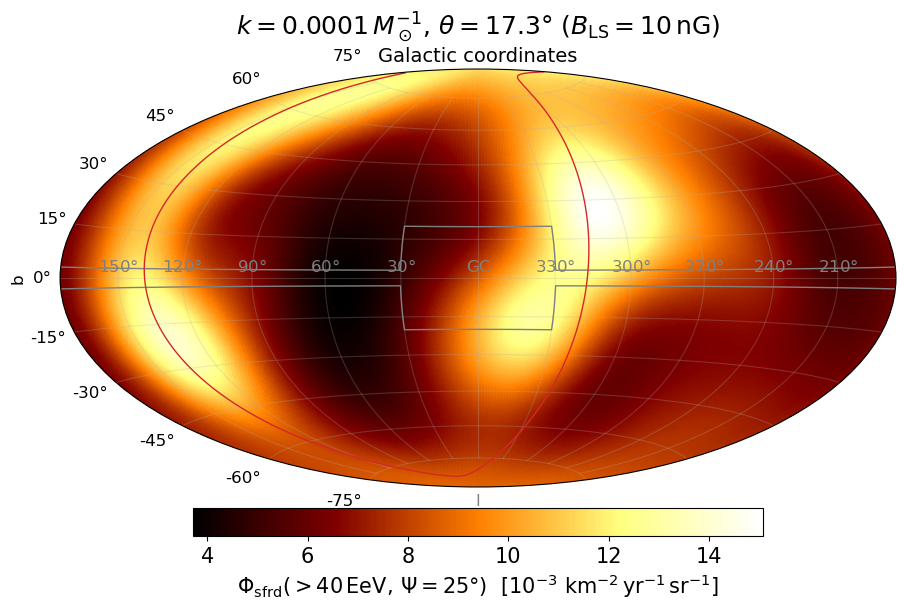

In [6]:
#Display parameters of the maps
if galCoord: ax_title = "Galactic coordinates"
else: ax_title = "Equatorial coordinates"
fig_name = "uhecr_fluxmap_"+str(np.around(logEth, decimals=2))+"_"+key+"_"+str(np.around(constant.B_LGMF_nG, decimals=2))+"_"+str(k_transient)
if smooth=="fisher": tex_ang = r"\theta"
elif smooth=="top-hat": tex_ang = r"\Psi"
Eth = np.around(np.power(10,logEth-18)).astype(int)
norm_fact_title = 1E3
color_bar_title = r"$\Phi_{\rm "+ key +r"}(>" + str(Eth) + r"\, {\rm EeV},\, "+tex_ang+" = "+ str(radius) +r"$°)"+ r"  $[10^{-3}\ \rm km^{-2}\, yr^{-1}\, sr^{-1}]$"
title = text_k+", "+text_deflection+r" ($B_{\rm LS} ="+str(constant.B_LGMF_nG) +r"\,$nG)"

#Plot
plt.rcParams.update({'font.size': 14,'legend.fontsize': 12})
map.PlotHPmap(norm_fact_title*Flux_map, nside, galCoord, title, color_bar_title, ax_title, fig_name = fig_name, write= SavePlot)	